# G-Formula for time-varying causal inference.

In [ ]:
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
import sys
sys.path.append('../')

In [4]:
from causallib.contrib.gformula import constants as C
from causallib.contrib.gformula import GFormula
from causallib.contrib.gformula.treament_strategy import Observational, CFBernoulli
from causallib.contrib.gformula.datasets import load_synth_dynamic_treat

# Load the data.

See [Data description](https://github.com/pchakraborty1/causallib/blob/test_cases_issue_1/causallib/contrib/gformula/datasets/synthetic_dynamic_treatment/README.md) for full details on how data was generated

In [5]:
data_obsv = load_synth_dynamic_treat(observational=True)
print(data_obsv.keys())

dict_keys(['train', 'val', 'test'])


In [6]:
X_train, a_train = data_obsv['train']
X_val, a_val = data_obsv['val']

In [7]:
X_train.head()

,id,time,cov1,cov2
0,64,0.0,-0.697242,-1.426433
1,64,1.0,-2.227926,1.289826
2,64,2.0,-0.062069,0.208838
3,64,3.0,0.821969,0.422134
4,64,4.0,-1.003137,0.570508


In [8]:
a_train.head()

,id,time,treatment
0,64,0.0,1
1,64,1.0,0
2,64,2.0,1
3,64,3.0,1
4,64,4.0,0


# Initialize
1. Covariate models in a sorted order for each covariate
2. Treatment model

In [9]:
covariate_models = {
    'cov1':  LinearRegression(),
    'cov2': LinearRegression()
}

treatment_models = {
    'treatment': LogisticRegression(solver='liblinear'), #RandomForestClassifier()
}

In [10]:
# Passing in a pre-fitted learner
covariate_models['cov1'].coef_ = np.array([1.0, 0., 1.0])
covariate_models['cov1'].intercept_ = 0.

In [11]:
gFormula = GFormula(treatment_models=treatment_models,
                    covariate_models=covariate_models,
                    outcome_model=None,
                    refit_models=False,
                    random_state=None,
                    mode='emp_mean_std', #C.DEFAULT_SIM_MODE,
                    )

# Fit the covariate and treatment models prior to estimate the outcome

In [12]:
gFormula.fit(X_train, a_train, t=None, y=None, X_val=X_val, a_val=a_val)

/opt/miniconda3/envs/gnet/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GFormula(covariate_models={'cov1': LinearRegression(), 'cov2': LinearRegression()}, id_col=id, mode=emp_mean_std, outcome_model=None, predict_proba=False, random_state=None, refit_models=False, time_col=time, treatment_models={'treatment': LogisticRegression(solver='liblinear')})

In [13]:
print(gFormula.all_cols_)
print(gFormula.covariate_models['cov1'].coef_, gFormula.covariate_models['cov1'].intercept_)
print(gFormula.covariate_models['cov2'].coef_, gFormula.covariate_models['cov2'].intercept_)

['prev_cov1', 'prev_cov2', 'prev_treatment', 'cov1', 'cov2', 'treatment']
[1. 0. 1.] 0.0
[-0.00710849  0.00352942 -0.00717639  0.00728613] -0.006493561418701044


# Estimate the outcomes
Define treatment strategy to be used to generate the treatment action for the simulation.

In [14]:
X_test, a_test = data_obsv['test']

## Observational strategy

In [15]:
# treatment_strategy = CFBernoulli()
# treatment_strategy = Observational(inverse_transform=None)
treatment_strategy = 'observational'

### Estimate the outcome in individual level

In [16]:
#a = df_obs[['id', 'A']]
est_outcome = gFormula.estimate_individual_outcome(X_test,
                                                   a_test,
                                                   t=None,
                                                   y=None,
                                                   treatment_strategy=treatment_strategy,
                                                   n_sims=3, #C.DEFAULT_N_SIMS
                                                   timeline_start=1,
                                                   n_jobs=C.DEFAULT_N_JOBS
                                                  )
est_outcome

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.0s finished


,cov1,cov2,treatment,id,time
0,2.519981,-0.208349,0.666667,604,1
1,2.647246,-0.474122,0.000000,604,2
2,1.354095,0.184529,0.666667,604,3
3,2.974869,0.067666,0.000000,604,4
4,2.072623,-0.169761,1.000000,604,5
...,...,...,...,...,...
43,25.611423,0.466805,0.333333,938,44
44,25.085016,-0.205217,0.666667,938,45
45,26.408481,0.046278,1.000000,938,46
46,26.700007,0.271274,1.000000,938,47


### Estimate the outcome in population level

In [17]:
# a = df_obs[['id', 'A']]
pop_outcome = gFormula.estimate_population_outcome(X_test,
                                                   a_test,
                                                   t=None,
                                                   y=None,
                                                   treatment_strategy=treatment_strategy,
                                                   n_sims=3, #C.DEFAULT_N_SIMS
                                                   timeline_start=1,
                                                   n_jobs=C.DEFAULT_N_JOBS
                                                  )
pop_outcome.reset_index(inplace=True)
pop_outcome

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.1778s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  70 out of 100 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.8s finished


,time,cov1,cov2,treatment,id
0,1,0.878182,0.032841,0.425,484.36
1,2,1.226958,0.212600,0.397,484.36
2,3,1.496984,0.096422,0.431,484.36
3,4,2.277852,0.152990,0.439,484.36
4,5,2.589336,0.072776,0.434,484.36
5,6,2.982520,-0.036496,0.434,484.36
6,7,3.347060,0.009434,0.432,484.36
7,8,3.857273,-0.139539,0.405,484.36
8,9,4.112635,0.128089,0.447,484.36
9,10,4.704842,0.040019,0.447,484.36


In [18]:
df_obsv_test = X_test.merge(a_test, on=[gFormula.id_col, gFormula.time_col])
obsv = df_obsv_test.groupby(df_obsv_test[gFormula.time_col]).mean()
obsv.reset_index(inplace=True)
obsv

,time,id,cov1,cov2,treatment
0,0.0,484.36,0.616603,0.173631,0.58
1,1.0,484.36,1.107350,0.090544,0.41
2,2.0,484.36,1.486855,0.118990,0.41
3,3.0,484.36,1.882139,0.088752,0.43
4,4.0,484.36,2.281510,-0.087161,0.41
5,5.0,484.36,2.650647,0.096411,0.37
6,6.0,484.36,3.034977,-0.077120,0.47
7,7.0,484.36,3.751684,0.090966,0.38
8,8.0,484.36,4.360516,0.262574,0.49
9,9.0,484.36,4.792487,0.059802,0.42


### Plot the Graph (Simulated Vs Observed) for covariates 'X', 'X2' and treatment 'a'

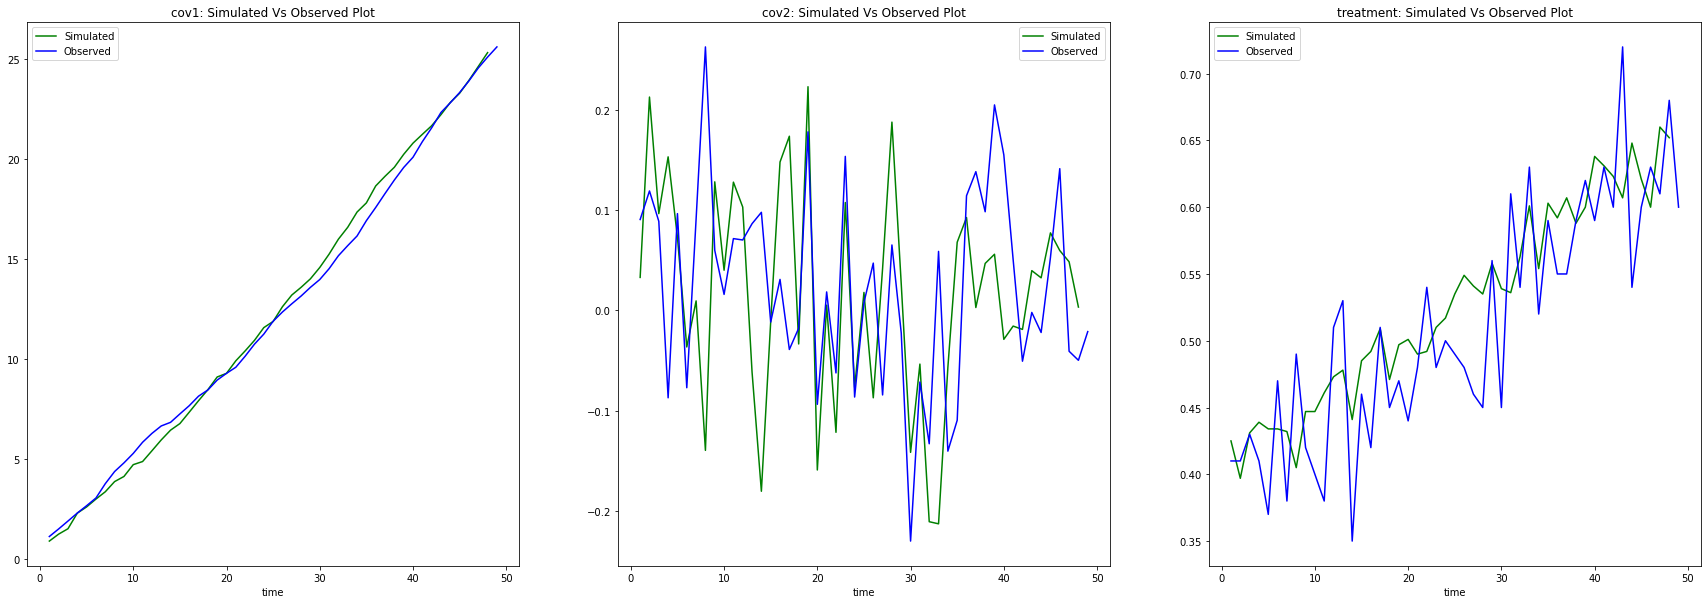

In [19]:
import matplotlib.pyplot as plt
#Get current axis
fig, axX = plt.subplots(1, 3, figsize=(30, 10))

for idx, y in enumerate(['cov1', 'cov2', 'treatment']):
    ax = axX.flatten()[idx]
    pop_outcome.plot(kind='line', x=gFormula.time_col, y=y, color='green', ax = ax)
    obsv.iloc[1:, :].plot(kind='line', x=gFormula.time_col, y=y, color='blue', ax = ax)
    ax.legend(['Simulated', 'Observed'])
    ax.set_title(f'{y}: Simulated Vs Observed Plot')

## Counterfactual Strategy

In [20]:
data_cf = load_synth_dynamic_treat(observational=False)
# print(data_cf.keys())
X_test, a_test = data_cf['test']

In [21]:
# treatment_strategy = CFBernoulli()
# treatment_strategy = Observational(inverse_transform=None)
treatment_strategy = 'never-treat'

### Estimate the outcome in individual level

In [22]:
#a = df_obs[['id', 'A']]
est_outcome = gFormula.estimate_individual_outcome(X_test,
                                                   a_test,
                                                   t=None,
                                                   y=None,
                                                   treatment_strategy=treatment_strategy,
                                                   n_sims=3, #C.DEFAULT_N_SIMS
                                                   timeline_start=1,
                                                   n_jobs=C.DEFAULT_N_JOBS
                                                  )
est_outcome

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.1575s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  70 out of 100 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.7s finished


,cov1,cov2,treatment,id,time
0,-0.595303,0.196764,0.0,0,1
1,-1.703240,-0.206215,0.0,0,2
2,-1.672523,0.177129,0.0,0,3
3,-0.889485,0.362638,0.0,0,4
4,-1.626891,-0.007723,0.0,0,5
...,...,...,...,...,...
43,5.780682,-0.574466,0.0,99,44
44,6.026506,0.222714,0.0,99,45
45,7.341804,1.003230,0.0,99,46
46,8.437525,-0.836293,0.0,99,47


## Estimate the outcome in population level

In [23]:
# a = df_obs[['id', 'A']]
pop_outcome = gFormula.estimate_population_outcome(X_test,
                                                   a_test,
                                                   t=None,
                                                   y=None,
                                                   treatment_strategy=treatment_strategy,
                                                   n_sims=3, #C.DEFAULT_N_SIMS
                                                   timeline_start=1,
                                                   n_jobs=C.DEFAULT_N_JOBS
                                                  )
pop_outcome.reset_index(inplace=True)
pop_outcome

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.1672s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  70 out of 100 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.7s finished


,time,cov1,cov2,treatment,id
0,1,0.350275,-0.024245,0.0,49.5
1,2,0.214708,0.233643,0.0,49.5
2,3,0.117509,-0.034296,0.0,49.5
3,4,0.439956,0.164074,0.0,49.5
4,5,0.281777,0.035436,0.0,49.5
5,6,0.223033,-0.104666,0.0,49.5
6,7,0.114569,0.007693,0.0,49.5
7,8,0.153893,-0.135472,0.0,49.5
8,9,-0.042548,0.136426,0.0,49.5
9,10,0.209022,0.055858,0.0,49.5


In [24]:
df_cf_test = X_test.merge(a_test, on=[gFormula.id_col, gFormula.time_col])
cf = df_cf_test.groupby(df_cf_test[gFormula.time_col]).mean()
cf.reset_index(inplace=True)
cf

,time,id,cov1,cov2,treatment
0,0.0,49.5,0.524024,0.029267,0.53
1,1.0,49.5,0.449459,0.128712,0.00
2,2.0,49.5,0.423707,-0.008143,0.00
3,3.0,49.5,0.371900,0.170726,0.00
4,4.0,49.5,0.494017,0.102643,0.00
5,5.0,49.5,0.432567,-0.154886,0.00
6,6.0,49.5,0.473951,0.037939,0.00
7,7.0,49.5,0.499103,-0.027926,0.00
8,8.0,49.5,0.432628,0.031695,0.00
9,9.0,49.5,0.368990,0.063415,0.00


# Plot the Graph (Simulated Vs Observed) for covariates 'X', 'X2' and treatment 'a'

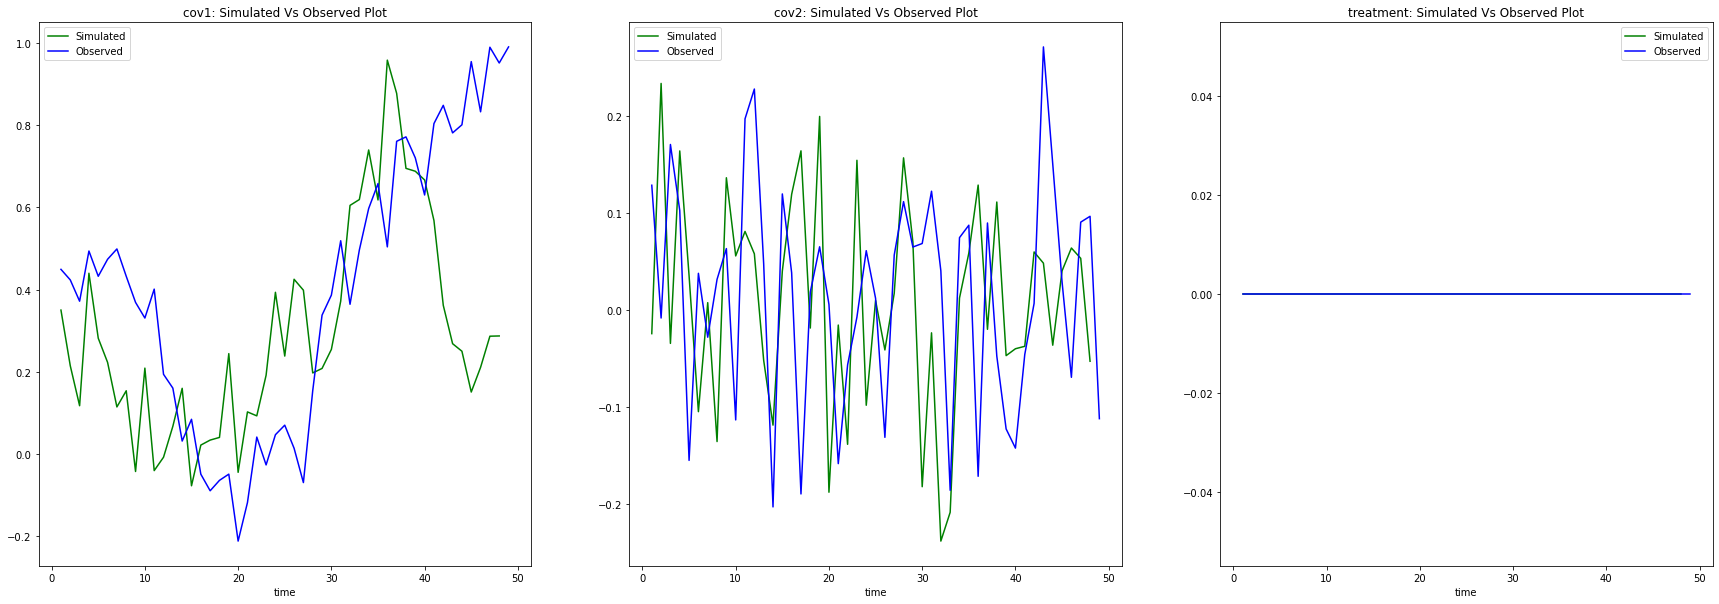

In [25]:
import matplotlib.pyplot as plt
#Get current axis
fig, axX = plt.subplots(1, 3, figsize=(30, 10))

for idx, y in enumerate(['cov1', 'cov2', 'treatment']):
    ax = axX.flatten()[idx]
    pop_outcome.plot(kind='line', x=gFormula.time_col, y=y, color='green', ax = ax)
    cf.iloc[1:,:].plot(kind='line', x=gFormula.time_col, y=y, color='blue', ax = ax)
    ax.legend(['Simulated', 'Observed'])
    ax.set_title(f'{y}: Simulated Vs Observed Plot')